# Tutorial: Analyze models and results
This tutorial demonstrates how to analyze the trained machine learning models to value on-the-ball actions of football players with the open-source [VAEP framework](https://github.com/ML-KULeuven/socceraction) using the publicly available [Wyscout match event dataset](https://figshare.com/collections/Soccer_match_event_dataset/4415000). The Wyscout dataset includes data for the 2017/2018 English Premier League, the 2017/2018 Spanish Primera División, the 2017/2018 German 1. Bundesliga, the 2017/2018 Italian Serie A, the 2017/2018 French Ligue 1, the 2018 FIFA World Cup, and the UEFA Euro 2016. Covering 1,941 matches, 3,251,294 events and 4,299 players, the dataset is large enough to train machine-learning models and obtain robust ratings for the players.

This tutorial demonstrates the following three steps:
   1. Analyze feature importances of the model.
   2. Analyze single predictions for game states.
   3. Analyze the player ratings that can be calculated using the two models trained in tutorial 3.

This notebook is compatible with `socceraction` version `0.2.0`.

**Conventions:**
   * Variables that refer a `DataFrame` object are prefixed with `df_`.
   * Variables that refer a collection of `DataFrame` objects (e.g., a list, a set or a dict) are prefixed with `dfs_`.
   
**References:**
   * Tom Decroos, Lotte Bransen, Jan Van Haaren, and Jesse Davis. \"[Actions Speak Louder than Goals: Valuing Player Actions in Soccer.](https://arxiv.org/abs/1802.07127)\" In *Proceedings of the 25th ACM SIGKDD International Conference on Knowledge Discovery & Data Mining*, pp. 1851-1861. 2019.
   * Luca Pappalardo, Paolo Cintia, Alessio Rossi, Emanuele Massucco, Paolo Ferragina, Dino Pedreschi, and Fosca Giannotti. \"[A Public Data Set of Spatio-Temporal Match Events in Soccer Competitions.](https://www.nature.com/articles/s41597-019-0247-7)\" *Scientific Data 6*, no. 1 (2019): 1-15."

**Optional:** If you run this notebook on Google Colab, then uncomment the code in the following cell and execute the cell.

In [292]:
# !pip install tables==3.6.1
# !pip install socceraction==0.2.0
# !pip install shap

**Optional:** If you run this notebook on Google Colab and wish to store all data in a Google Drive folder, then uncomment the code in the following cell and execute the cell.

In [293]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# %mkdir -p '/content/gdrive/My Drive/Friends of Tracking/'
# %cd '/content/gdrive/My Drive/Friends of Tracking/'

In [294]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
from ipywidgets import fixed, interact_manual, widgets
from socceraction.vaep.formula import value
from tqdm import tqdm
from xgboost import XGBClassifier, plot_importance

In [295]:
warnings.filterwarnings('ignore', category=pd.io.pytables.PerformanceWarning)

In [296]:
%matplotlib inline

# Load dataset

This fourth tutorial assumes that the spadl.h5 HDF5 file as well as the features.h5, labels.h5 and predictions.h5 files have been created for a set of games in the first or second tutorial.

This fourth tutorial only uses features that have been generated in the first tutorial. However, you are strongly encouraged to toy around with the additional features from the second tutorial and to try out your own features to improve the accuracy of the predictive machine learning models!

## Load games

In [297]:
df_games = pd.read_hdf('spadl.h5', key='games')

In this notebook we will use the trained models to rate actions for all actions from the 2017/2018 Spanish La Liga (competition_id = 795). Therefore, we make sure that we don't use this data when training and tuning the model.

In [298]:
df_games_train = df_games[
    df_games['competition_id'] != 524 #Esp 795 # Ita 524 # Eng 364 
]

In [299]:
df_games_train.tail(10)

,game_id,competition_id,season_id,game_date,home_team_id,away_team_id
54,2057984,28,10078,2018-06-17 15:00:00,3148,15473
55,2057979,28,10078,2018-06-17 12:00:00,16871,17322
56,2057973,28,10078,2018-06-16 19:00:00,9598,16823
57,2057967,28,10078,2018-06-16 16:00:00,15594,7712
58,2057972,28,10078,2018-06-16 13:00:00,12274,7839
59,2057966,28,10078,2018-06-16 10:00:00,4418,8493
60,2057960,28,10078,2018-06-15 18:00:00,9905,1598
61,2057961,28,10078,2018-06-15 15:00:00,16216,10840
62,2057955,28,10078,2018-06-15 12:00:00,16129,15670
63,2057954,28,10078,2018-06-14 15:00:00,14358,16521


In [300]:
df_games_test = df_games[
    df_games['competition_id'] == 524 #795 #524 #364 
]

In [301]:
df_games_test.tail(10)

,game_id,competition_id,season_id,game_date,home_team_id,away_team_id
370,2575960,524,181248,2017-08-20 18:45:00,3166,3185
371,2575961,524,181248,2017-08-20 18:45:00,3197,3157
372,2575963,524,181248,2017-08-20 18:45:00,3161,3176
373,2575965,524,181248,2017-08-20 18:45:00,3162,3204
374,2575966,524,181248,2017-08-20 18:45:00,3164,3219
375,2575967,524,181248,2017-08-20 18:45:00,3315,3193
376,2575968,524,181248,2017-08-20 18:45:00,3163,3165
377,2575959,524,181248,2017-08-20 16:00:00,3172,3158
378,2575962,524,181248,2017-08-19 18:45:00,3194,3187
379,2575964,524,181248,2017-08-19 16:00:00,3159,3173


## Load features

Load the features for the selected games and combine them into the df_features DataFrame object.

In [302]:
dfs_features = []
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    df_features = pd.read_hdf('features.h5', key=f'game_{game_id}')
    df_features['game_id'] = game_id
    dfs_features.append(df_features)
df_features = pd.concat(dfs_features).reset_index(drop=True)

100%|██████████████████████████████████████████████████████████████████████████████| 1941/1941 [00:41<00:00, 47.04it/s]


In [303]:
df_features.tail(10)

,game_id-0,period_id-0,time_seconds-0,team_id-0,player_id-0,start_x-0,start_y-0,end_x-0,end_y-0,bodypart_id-0,...,end_x_norm-2,end_y_norm-2,end_distance_to_goal-2,end_angle_to_goal-2,xdiff_sequence_pre,ydiff_sequence_pre,time_sequence_pre,xdiff_sequence_post,ydiff_sequence_post,game_id
2464869,2057954.0,2.0,2860.543201,14358.0,102157.0,58.80,41.48,58.80,38.08,0,...,0.64,0.44,38.019553,9.264706,4.20,14.28,5.269374,4.20,10.88,2057954
2464870,2057954.0,2.0,2861.719049,14358.0,102157.0,58.80,38.08,69.30,45.56,0,...,0.56,0.61,46.801607,6.176471,-8.40,8.16,4.900802,2.10,15.64,2057954
2464871,2057954.0,2.0,2863.131899,14358.0,4513.0,69.30,45.56,55.65,42.16,0,...,0.56,0.56,46.379806,11.323529,10.50,4.08,2.588698,-3.15,0.68,2057954
2464872,2057954.0,2.0,2864.548384,14358.0,220971.0,55.65,42.16,72.45,24.48,0,...,0.66,0.67,37.524973,3.088235,-3.15,4.08,2.829335,13.65,-13.60,2057954
2464873,2057954.0,2.0,2865.964868,14358.0,220971.0,72.45,24.48,76.65,19.04,0,...,0.53,0.62,50.020077,6.047794,3.15,-21.08,2.832969,7.35,-26.52,2057954
2464874,2057954.0,2.0,2868.496551,14358.0,103682.0,76.65,19.04,81.90,20.40,0,...,0.69,0.36,33.913609,3.419118,21.00,-23.12,3.948167,26.25,-21.76,2057954
2464875,2057954.0,2.0,2870.980334,16521.0,122577.0,81.90,20.40,80.85,25.16,0,...,0.27,0.72,78.096249,5.123663,49.35,-23.12,5.015466,48.30,-18.36,2057954
2464876,2057954.0,2.0,2872.843120,16521.0,122577.0,80.85,25.16,80.85,25.16,0,...,0.22,0.70,83.021503,6.022059,52.50,-23.80,4.346569,52.50,-23.80,2057954
2464877,2057954.0,2.0,2939.438099,14358.0,257800.0,85.05,22.44,105.00,30.60,0,...,0.23,0.63,81.331839,9.145928,61.95,-25.16,68.457765,81.90,-17.00,2057954
2464878,2057954.0,2.0,2983.382036,16521.0,122623.0,52.50,34.00,0.00,68.00,0,...,0.77,0.37,25.717078,2.731900,-28.35,8.84,110.538916,-80.85,42.84,2057954


## Load labels

Load the labels for the selected games and combine them into the df_labels DataFrame object.

In [304]:
dfs_labels = []
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']  
    df_labels = pd.read_hdf('labels.h5', key=f'game_{game_id}')
    df_labels['game_id'] = game_id
    dfs_labels.append(df_labels)
df_labels = pd.concat(dfs_labels).reset_index(drop=True)

100%|█████████████████████████████████████████████████████████████████████████████| 1941/1941 [00:10<00:00, 188.55it/s]


In [305]:
df_labels.tail(10)

,scores,concedes,game_id
2464869,True,False,2057954
2464870,True,False,2057954
2464871,True,False,2057954
2464872,True,False,2057954
2464873,True,False,2057954
2464874,True,False,2057954
2464875,False,True,2057954
2464876,False,True,2057954
2464877,True,False,2057954
2464878,False,False,2057954


## Split the data and train the model

This fourth tutorial assumes that you followed the third tutorial. In that tutorial it is explained in detail how you can split the data and train your own models.

In [306]:
df_X_train = df_features[df_features['game_id'].isin(df_games_train['game_id'].unique())]
df_X_test = df_features[df_features['game_id'].isin(df_games_test['game_id'].unique())]
df_y_train = df_labels[df_labels['game_id'].isin(df_games_train['game_id'].unique())]
df_y_test = df_labels[df_labels['game_id'].isin(df_games_test['game_id'].unique())]

In [307]:
df_X_train.columns

Index(['game_id-0', 'period_id-0', 'time_seconds-0', 'team_id-0',
       'player_id-0', 'start_x-0', 'start_y-0', 'end_x-0', 'end_y-0',
       'bodypart_id-0', 'type_id-0', 'result_id-0', 'type_name-0',
       'result_name-0', 'bodypart_name-0', 'time_played-0', 'game_id-1',
       'period_id-1', 'time_seconds-1', 'team_id-1', 'player_id-1',
       'start_x-1', 'start_y-1', 'end_x-1', 'end_y-1', 'bodypart_id-1',
       'type_id-1', 'result_id-1', 'type_name-1', 'result_name-1',
       'bodypart_name-1', 'time_played-1', 'game_id-2', 'period_id-2',
       'time_seconds-2', 'team_id-2', 'player_id-2', 'start_x-2', 'start_y-2',
       'end_x-2', 'end_y-2', 'bodypart_id-2', 'type_id-2', 'result_id-2',
       'type_name-2', 'result_name-2', 'bodypart_name-2', 'time_played-2',
       'team-1', 'team-2', 'start_x_norm-0', 'start_y_norm-0',
       'start_distance_to_goal-0', 'start_angle_to_goal-0', 'diff_x-0',
       'diff_y-0', 'distance_covered-0', 'end_x_norm-0', 'end_y_norm-0',
       'en

The following cell provides a list of features that the machine learning algorithm will consider to train the model. The selected features exist in the features.h5 file that was created in the second tutorial.

In [308]:
#fetures=df_X_train.columns

features = [
    'start_distance_to_goal-0',
    'end_distance_to_goal-0',
    'start_distance_to_goal-1',
    'end_distance_to_goal-1',
    'start_distance_to_goal-2',
    'end_distance_to_goal-2',
    'start_angle_to_goal-0',
    'end_angle_to_goal-0',
    'start_angle_to_goal-1',
    'end_angle_to_goal-1',
    'start_angle_to_goal-2',
    'end_angle_to_goal-2',
    'team-1',
    'team-2',
    'result_id-0',
    'result_id-1',
    'result_id-2'
]


The following cell provides a list of class labels for which the machine learning algorithm will train a model.

Note: The concedes class label has been commented to speed up the execution of the entire notebook.

In [309]:
labels = [
    'scores',
    'concedes'
]

## Train classifiers

The following cell trains an XGBoost classifier for each label using conservative hyperparamters for the learning algorithm, which will serve as baseline models.

In [310]:
models = {}
for label in tqdm(labels):
    model = XGBClassifier(
        eval_metric='logloss',
        use_label_encoder=False,
        n_estimators=100,
        max_depth=4
    )
    model.fit(
        X=df_X_train[features],
        y=df_y_train[label]
    )
    models[label] = model

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [05:05<00:00, 152.78s/it]


## Investigate feature importances

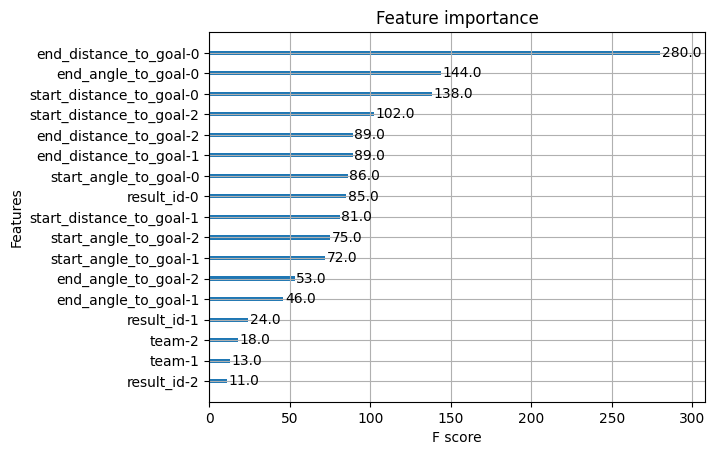

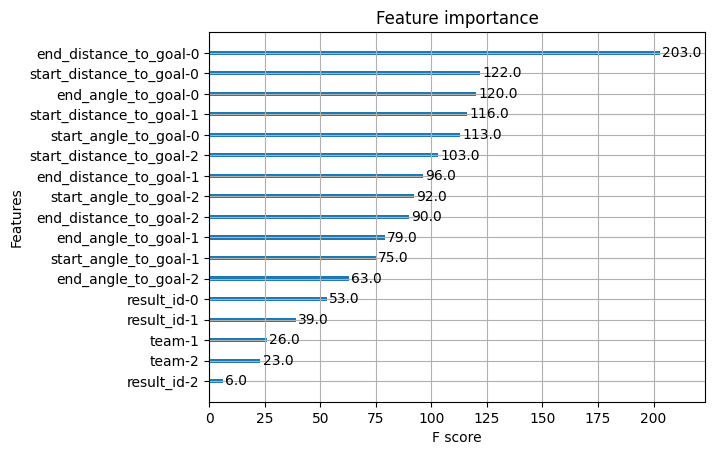

In [311]:
for label in labels:
    plot_importance(models[label])

## Investigate SHAP values

For more information: https://github.com/slundberg/shap

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


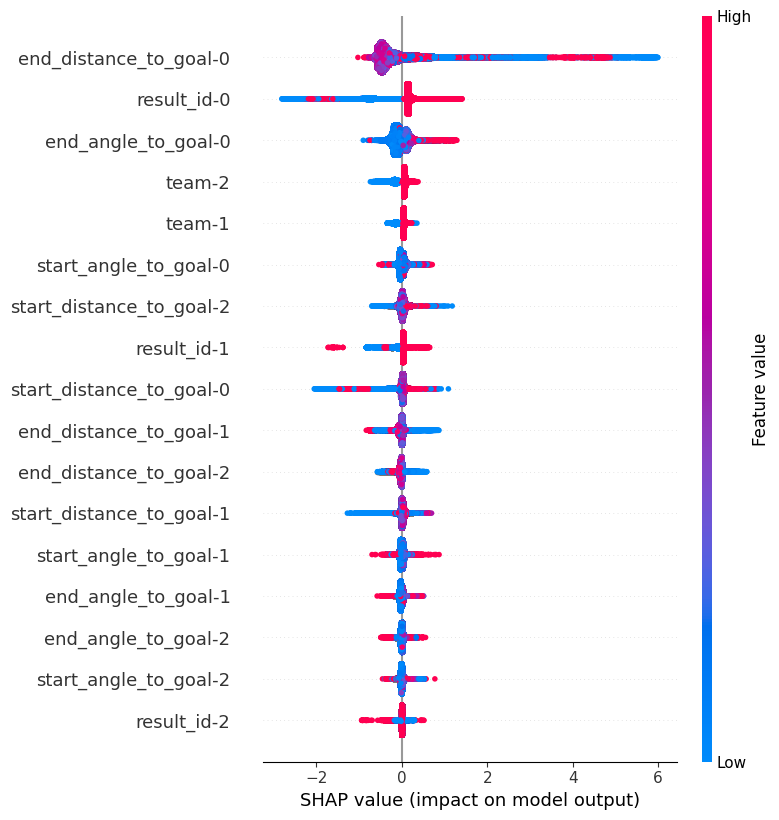

In [312]:
label='scores'
# label='concedes'

explainer = shap.TreeExplainer(models[label])

shap_values = explainer.shap_values(df_X_test[features])
shap.summary_plot(shap_values, df_X_test[features])

## Estimate probabilities

The following cell estimates the probabilities for the game states in the test set for each label using the trained models.

In [313]:
dfs_predictions = {}
for label in tqdm(labels):
    model = models[label]
    probabilities = model.predict_proba(
        df_X_test[features]
    )
    predictions = probabilities[:, 1]
    dfs_predictions[label] = pd.Series(predictions, index=df_X_test.index)
df_predictions = pd.concat(dfs_predictions, axis=1).reset_index(drop=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.45it/s]


In [314]:
df_predictions.tail(10)

,scores,concedes
495961,0.007179,0.019314
495962,0.007987,0.009493
495963,0.011757,0.003332
495964,0.011720,0.002350
495965,0.006381,0.006656
495966,0.029657,0.002697
495967,0.056771,0.003719
495968,0.096970,0.003923
495969,0.009560,0.004915
495970,0.003924,0.006762


## Load actions, players and teams and value actions

In [315]:
df_players = pd.read_hdf('spadl.h5', key='players')
df_teams = pd.read_hdf('spadl.h5', key='teams')

In [316]:
dfs_actions = []
for _, game in tqdm(df_games_test.iterrows(), total=len(df_games_test)):
    game_id = game['game_id']
    with pd.HDFStore('spadl.h5') as spadlstore:
        df_actions = spadlstore[f'actions/game_{game_id}']
        df_actions = (
            df_actions.merge(spadlstore['actiontypes'], how='left')
            .merge(spadlstore['results'], how='left')
            .merge(spadlstore['bodyparts'], how='left')
            .merge(spadlstore['players'], how='left')
            .merge(spadlstore['teams'], how='left')
            .reset_index()
            .rename(columns={'index': 'action_id'})
        )
    
    dfs_actions.append(df_actions)
df_actions = pd.concat(dfs_actions).reset_index(drop=True)

100%|████████████████████████████████████████████████████████████████████████████████| 380/380 [00:27<00:00, 13.78it/s]


In [317]:
df_actions_predictions = pd.concat([df_actions, df_predictions], axis=1)

In [318]:
dfs_values = []
for game_id, game_predictions in df_actions_predictions.groupby('game_id'):
    df_values = value(game_predictions, game_predictions['scores'], game_predictions['concedes'])
    
    df_all = pd.concat([game_predictions, df_values], axis=1)
    dfs_values.append(df_all)

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexin

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexin

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexin

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexin

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexin

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexin

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexin

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexin

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexin

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexin

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexin

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexin

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexin

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexin

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexin

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexin

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexin

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexin

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexin

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexin

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexin

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexin

In [319]:
df_values = (pd.concat(dfs_values)
    .sort_values(['game_id', 'period_id', 'time_seconds'])
    .reset_index(drop=True)
)

In [320]:
df_values.tail(10)

,action_id,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,...,first_name,last_name,birth_date,short_team_name,team_name,scores,concedes,offensive_value,defensive_value,vaep_value
495961,1179,2576338.0,2.0,2571.850146,3193.0,116269.0,54.60,56.44,72.45,45.5600,...,Diego Sebastián,Laxalt Suárez,1993-02-07,Genoa,Genoa CFC,0.013558,0.002296,0.007384,0.001231,0.008615
495962,1180,2576338.0,2.0,2576.793672,3193.0,116269.0,72.45,45.56,81.90,33.3200,...,Diego Sebastián,Laxalt Suárez,1993-02-07,Genoa,Genoa CFC,0.027144,0.002820,0.013587,-0.000524,0.013063
495963,1181,2576338.0,2.0,2578.550581,3193.0,3548.0,81.90,33.32,97.65,38.7600,...,Giuseppe,Rossi,1987-02-01,Genoa,Genoa CFC,0.086586,0.002131,0.059442,0.000688,0.060130
495964,1182,2576338.0,2.0,2579.867806,3193.0,21177.0,97.65,38.76,105.00,30.3416,...,Goran,Pandev,1983-07-27,Genoa,Genoa CFC,0.038349,0.007166,-0.048237,-0.005034,-0.053271
495965,1183,2576338.0,2.0,2615.710407,3185.0,283062.0,100.00,34.00,36.75,68.0000,...,Vanja,Milinković-Savić,1997-02-20,Torino,Torino FC,0.002653,0.001221,0.002653,-0.001221,0.001432
495966,1184,2576338.0,2.0,2630.727964,3193.0,20749.0,38.85,68.00,45.15,55.0800,...,Andrea,Bertolacci,1991-01-11,Genoa,Genoa CFC,0.005576,0.003079,0.005576,-0.003079,0.002497
495967,1185,2576338.0,2.0,2633.465692,3193.0,0.0,45.15,55.08,63.00,53.0400,...,NaN,NaN,NaN,Genoa,Genoa CFC,0.011198,0.002393,0.005622,0.000685,0.006307
495968,1186,2576338.0,2.0,2636.203420,3193.0,0.0,63.00,53.04,65.10,55.0800,...,NaN,NaN,NaN,Genoa,Genoa CFC,0.011695,0.002159,0.000498,0.000234,0.000732
495969,1187,2576338.0,2.0,2637.177535,3193.0,116269.0,65.10,55.08,66.15,51.0000,...,Diego Sebastián,Laxalt Suárez,1993-02-07,Genoa,Genoa CFC,0.010744,0.002150,-0.000951,0.000009,-0.000942
495970,1188,2576338.0,2.0,2638.693956,3185.0,289827.0,66.15,51.00,66.15,51.0000,...,Kevin,Bonifazi,1996-05-19,Torino,Torino FC,0.007362,0.005074,0.005212,0.005670,0.010882


In [321]:
df_values_csv=df_values

# Rate players

We investigate the ratings per player and look at the quantity-quality trade-off, risk-reward trade-off and the rating per player per action type (e.g. shot, pass, tackle, etc.)

In [322]:
df_values.head()

,action_id,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,...,first_name,last_name,birth_date,short_team_name,team_name,scores,concedes,offensive_value,defensive_value,vaep_value
0,0,2575959.0,1.0,2.530536,3158.0,8327.0,53.55,35.36,59.85,29.92,...,Edin,Džeko,1986-03-17,Roma,AS Roma,0.002654,0.000289,0.000000,-0.000000e+00,0.000000
1,1,2575959.0,1.0,3.768418,3158.0,20438.0,59.85,29.92,67.20,11.56,...,Daniele,De Rossi,1983-07-24,Roma,AS Roma,0.003235,0.000407,0.000581,-1.181274e-04,0.000462
2,2,2575959.0,1.0,5.941547,3158.0,8306.0,67.20,11.56,23.10,38.08,...,Aleksandar,Kolarov,1985-11-10,Roma,AS Roma,0.028206,0.001840,0.024972,-1.432360e-03,0.023539
3,3,2575959.0,1.0,8.114676,3158.0,8306.0,23.10,38.08,37.80,10.20,...,Aleksandar,Kolarov,1985-11-10,Roma,AS Roma,0.008769,0.002044,-0.019437,-2.042372e-04,-0.019641
4,4,2575959.0,1.0,8.647892,3158.0,8306.0,37.80,10.20,29.40,10.20,...,Aleksandar,Kolarov,1985-11-10,Roma,AS Roma,0.010320,0.002045,0.001550,-7.830095e-07,0.001550


In [323]:
df_ranking = (df_values[['player_id', 'short_name','team_id', 'team_name', 'vaep_value','offensive_value','defensive_value']]
    .groupby(['player_id', 'short_name', 'team_id', 'team_name'])
    .agg(vaep_count=('vaep_value', 'count'), 
         vaep_mean=('vaep_value', 'mean'),
         vaep_sum=('vaep_value', 'sum'),
         vaep_sum_Offensive=('offensive_value', 'sum'),
         vaep_mean_Offensive=('offensive_value', 'mean'),
         vaep_sum_defensive=('defensive_value', 'sum'),
         vaep_mean_defensive=('defensive_value', 'mean')
        )
    .sort_values('vaep_sum', ascending=False)
    .reset_index()
)

In [324]:
df_ranking.head(10)

,player_id,short_name,team_id,team_name,vaep_count,vaep_mean,vaep_sum,vaep_sum_Offensive,vaep_mean_Offensive,vaep_sum_defensive,vaep_mean_defensive
0,21384.0,C. Immobile,3162.0,SS Lazio,1196,0.015835,18.938157,19.549809,0.016346,-0.611651,-0.000511
1,206314.0,M. Icardi,3161.0,FC Internazionale Milano,709,0.024896,17.651383,18.181736,0.025644,-0.530353,-0.000748
2,89186.0,P. Dybala,3159.0,Juventus FC,1782,0.009788,17.442517,18.377287,0.010313,-0.934770,-0.000525
3,265865.0,S. Milinković-Savić,3162.0,SS Lazio,2359,0.006416,15.136493,14.265391,0.006047,0.871102,0.000369
4,8148.0,Iago Falqué,3185.0,Torino FC,1859,0.007575,14.081121,14.546781,0.007825,-0.465661,-0.000250
5,3484.0,Luis Alberto,3162.0,SS Lazio,2292,0.005996,13.743605,15.085408,0.006582,-1.341804,-0.000585
6,3323.0,G. Higuaín,3159.0,Juventus FC,1137,0.011374,12.932179,13.247632,0.011651,-0.315453,-0.000277
7,130.0,S. de Vrij,3162.0,SS Lazio,2031,0.006252,12.698804,11.064357,0.005448,1.634447,0.000805
8,138408.0,M. Škriniar,3161.0,FC Internazionale Milano,2879,0.004286,12.339165,10.662062,0.003703,1.677102,0.000583
9,20443.0,M. Pjanić,3159.0,Juventus FC,2599,0.004682,12.168943,12.021654,0.004625,0.147289,0.000057


In [325]:
df_player_games = pd.read_hdf('spadl.h5', 'player_games')
df_player_games = df_player_games[df_player_games['game_id'].isin(df_games['game_id'])]

In [326]:
df_minutes_played = (df_player_games[['player_id', 'minutes_played']]
    .groupby('player_id')
    .sum()
    .reset_index()
)

In [327]:
df_minutes_played.head()

,player_id,minutes_played
0,0,21.965164
1,12,186.155078
2,33,92.903192
3,36,2267.922277
4,38,382.741398


In [328]:
df_ranking_p90 = df_ranking.merge(df_minutes_played)
df_ranking_p90['vaep_rating'] = df_ranking_p90['vaep_sum'] * 90 / df_ranking_p90['minutes_played']
df_ranking_p90['actions_p90'] = df_ranking_p90['vaep_count'] * 90 / df_ranking_p90['minutes_played']

In [329]:
df_ranking_p90_csv=df_ranking_p90 #Creo esta variable para exportar los datos
df_ranking_p90_csv.head()

,player_id,short_name,team_id,team_name,vaep_count,vaep_mean,vaep_sum,vaep_sum_Offensive,vaep_mean_Offensive,vaep_sum_defensive,vaep_mean_defensive,minutes_played,vaep_rating,actions_p90
0,21384.0,C. Immobile,3162.0,SS Lazio,1196,0.015835,18.938157,19.549809,0.016346,-0.611651,-0.000511,2907.047792,0.586311,37.027255
1,206314.0,M. Icardi,3161.0,FC Internazionale Milano,709,0.024896,17.651383,18.181736,0.025644,-0.530353,-0.000748,3060.123799,0.519137,20.852098
2,89186.0,P. Dybala,3159.0,Juventus FC,1782,0.009788,17.442517,18.377287,0.010313,-0.934770,-0.000525,2477.563907,0.633617,64.732942
3,265865.0,S. Milinković-Savić,3162.0,SS Lazio,2359,0.006416,15.136493,14.265391,0.006047,0.871102,0.000369,3248.350621,0.419377,65.359324
4,8148.0,Iago Falqué,3185.0,Torino FC,1859,0.007575,14.081121,14.546781,0.007825,-0.465661,-0.000250,2906.319576,0.436050,57.567654


In [330]:
MIN_THRESHOLD = 450

In [331]:
df_ranking_p90 = df_ranking_p90[df_ranking_p90['minutes_played']>MIN_THRESHOLD]

In [332]:
df_ranking_p90 = df_ranking_p90.sort_values('vaep_rating', ascending=False)
df_ranking_p90.head(10)

,player_id,short_name,team_id,team_name,vaep_count,vaep_mean,vaep_sum,vaep_sum_Offensive,vaep_mean_Offensive,vaep_sum_defensive,vaep_mean_defensive,minutes_played,vaep_rating,actions_p90
91,25601.0,C. Diabaté,3219.0,Benevento Calcio,177,0.035986,6.369461,6.440369,0.036386,-0.070908,-0.000401,713.032583,0.803962,22.341195
2,89186.0,P. Dybala,3159.0,Juventus FC,1782,0.009788,17.442517,18.377287,0.010313,-0.934770,-0.000525,2477.563907,0.633617,64.732942
0,21384.0,C. Immobile,3162.0,SS Lazio,1196,0.015835,18.938157,19.549809,0.016346,-0.611651,-0.000511,2907.047792,0.586311,37.027255
237,491409.0,M. Barrow,3172.0,Atalanta Bergamasca Calcio,200,0.014475,2.895003,2.990870,0.014954,-0.095867,-0.000479,472.201289,0.551778,38.119337
159,99511.0,M. Stępiński,3165.0,AC Chievo Verona,253,0.018248,4.616671,4.455171,0.017609,0.161500,0.000638,786.332615,0.528403,28.957212
1,206314.0,M. Icardi,3161.0,FC Internazionale Milano,709,0.024896,17.651383,18.181736,0.025644,-0.530353,-0.000748,3060.123799,0.519137,20.852098
18,20820.0,J. Iličić,3172.0,Atalanta Bergamasca Calcio,1697,0.006488,11.009970,12.028199,0.007088,-1.018228,-0.000600,2077.921426,0.476869,73.501336
97,40806.0,Felipe Anderson,3162.0,SS Lazio,1022,0.006089,6.222559,6.545382,0.006404,-0.322823,-0.000316,1221.511377,0.458473,75.300158
5,3484.0,Luis Alberto,3162.0,SS Lazio,2292,0.005996,13.743605,15.085408,0.006582,-1.341804,-0.000585,2761.026859,0.447994,74.711334
88,72397.0,Simy,3197.0,FC Crotone,468,0.013709,6.415717,6.330621,0.013527,0.085096,0.000182,1298.807371,0.444573,32.429751


## Quantity - quality trade-off

In the next cell we create a figure to analyze the quantity-quality trade-off. The VAEP rating per player per 90 minutes depends on the average rating per action and the number of actions per 90 minutes. Some players have high ratings because they execute a lot of actions per 90 minutes, while others have very high average ratings.

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.


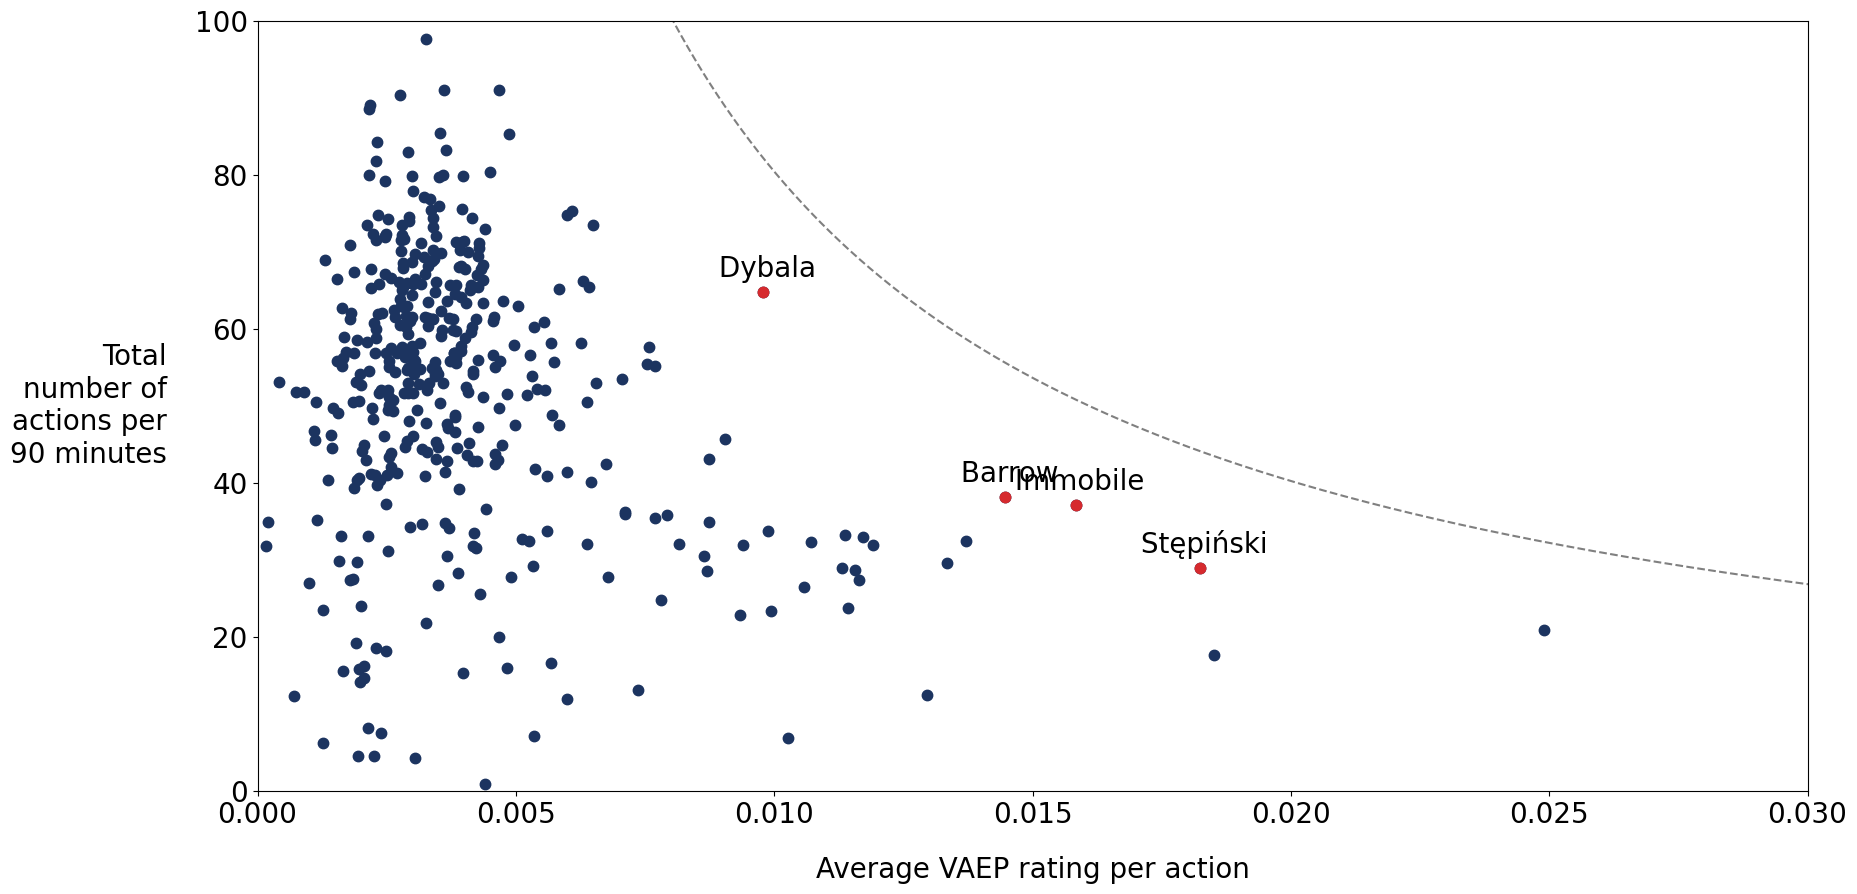

In [333]:
plt.figure(figsize=(20, 10))
x = list(df_ranking_p90['vaep_mean'])
y = list(df_ranking_p90['actions_p90'])
plt.plot(x, y, '.', c='#1C3460', markersize=15)

# Plot 5 best players
x_best = list(df_ranking_p90['vaep_mean'][0:5])
y_best = list(df_ranking_p90['actions_p90'][0:5])
names = list(df_ranking_p90['short_name'][0:5])
names = [name.split(".")[-1] for name in names]
plt.plot(x_best, y_best, '.', c='#D62A2E', markersize=15)
for i, txt in enumerate(names):
    plt.annotate(txt, (x[i], y[i] + 2), fontsize=20, horizontalalignment='center')

best_player = x[0] * y[0]
yi = np.arange(0.1, 100, 0.1)
xi = [best_player / i for i in yi]
plt.plot(xi, yi, '--', c='grey')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(0, 0.03)
plt.ylim(0, 100)
plt.xlabel('Average VAEP rating per action', labelpad=20, fontsize=20)
plt.ylabel('Total\nnumber of\nactions per\n90 minutes', rotation=0, labelpad=20,
            verticalalignment='center', horizontalalignment='right', fontsize=20)

plt.show()

## Risk - reward trade-off

In the next cells we will look at the ratings for a player's successful actions and for the player's unsuccessful actions. In this way we can identify players that take more risk, and players that play less risky.

In [334]:
df_risk = pd.pivot_table(df_values, values='vaep_value', index=['player_id', 'short_name', 'team_name'],
                                              columns=['result_name'], aggfunc=np.sum,
                                              fill_value=0)[['success', 'fail']]
df_risk = df_risk.reset_index()
df_risk = df_risk[0:-1]
df_risk = pd.merge(df_risk, df_minutes_played, on=['player_id'])


#for result in ['success', 'fail']:
    #df_risk[result] = df_risk[result] / df_risk['minutes_played'] * 90
    
df_risk['success_sum'] = df_risk['success']
df_risk['fail_sum'] = df_risk['fail']
df_risk['success'] = df_risk['success'] / df_risk['minutes_played'] * 90
df_risk['fail'] = df_risk['fail'] / df_risk['minutes_played'] * 90
    

In [335]:
df_risk_csv=df_risk
df_risk_csv['vaep_risk_rating'] = df_risk['success'] + df_risk['fail']
df_risk_csv.head()

,player_id,short_name,team_name,success,fail,minutes_played,success_sum,fail_sum,vaep_risk_rating
0,45.0,G. van der Wiel,Cagliari Calcio,0.191914,-0.000149,313.762114,0.669060,-0.000518,0.191765
1,114.0,K. Strootman,AS Roma,0.289281,-0.092856,2354.737384,7.568673,-2.429474,0.196424
2,122.0,D. Mertens,SSC Napoli,0.452098,-0.165195,3577.974246,17.973266,-6.567381,0.286902
3,130.0,S. de Vrij,SS Lazio,0.393593,-0.028305,3144.450117,13.751498,-0.988930,0.365288
4,174.0,F. Đuričić,Benevento Calcio,0.189301,-0.139745,1016.553579,2.138167,-1.578426,0.049556


In [336]:
df_risk = df_risk[df_risk['minutes_played']>MIN_THRESHOLD]
df_risk['vaep_rating'] = df_risk['success'] + df_risk['fail']
df_risk.sort_values('fail')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,player_id,short_name,team_name,success,fail,minutes_played,success_sum,fail_sum,vaep_risk_rating,vaep_rating
78,20478.0,A. Matri,US Sassuolo Calcio,0.291488,-0.264177,982.600991,3.182406,-2.884228,0.027311,0.027311
17,3475.0,D. Perotti,AS Roma,0.429588,-0.248420,1680.993584,8.023710,-4.639909,0.181168,0.181168
201,21385.0,L. Insigne,SSC Napoli,0.441950,-0.244115,3205.650420,15.741535,-8.694982,0.197835,0.197835
165,21077.0,A. Gómez,Atalanta Bergamasca Calcio,0.439315,-0.234332,2853.763457,13.930025,-7.430301,0.204984,0.204984
136,20820.0,J. Iličić,Atalanta Bergamasca Calcio,0.714016,-0.233084,2077.921426,16.485220,-5.381451,0.480932,0.480932
...,...,...,...,...,...,...,...,...,...,...
275,25558.0,N. N'Koulou,Torino FC,0.330201,-0.009273,3400.673739,12.476751,-0.350376,0.320929,0.320929
74,20468.0,E. Giaccherini,SSC Napoli,0.018727,-0.008595,1379.905755,0.287135,-0.131776,0.010133,0.010133
302,49979.0,D. Pavlovic,UC Sampdoria,0.045181,-0.005925,880.062204,0.441804,-0.057937,0.039256,0.039256
125,20748.0,N. Tomović,ACF Fiorentina,0.017374,-0.004645,2547.607576,0.491814,-0.131490,0.012729,0.012729


The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.


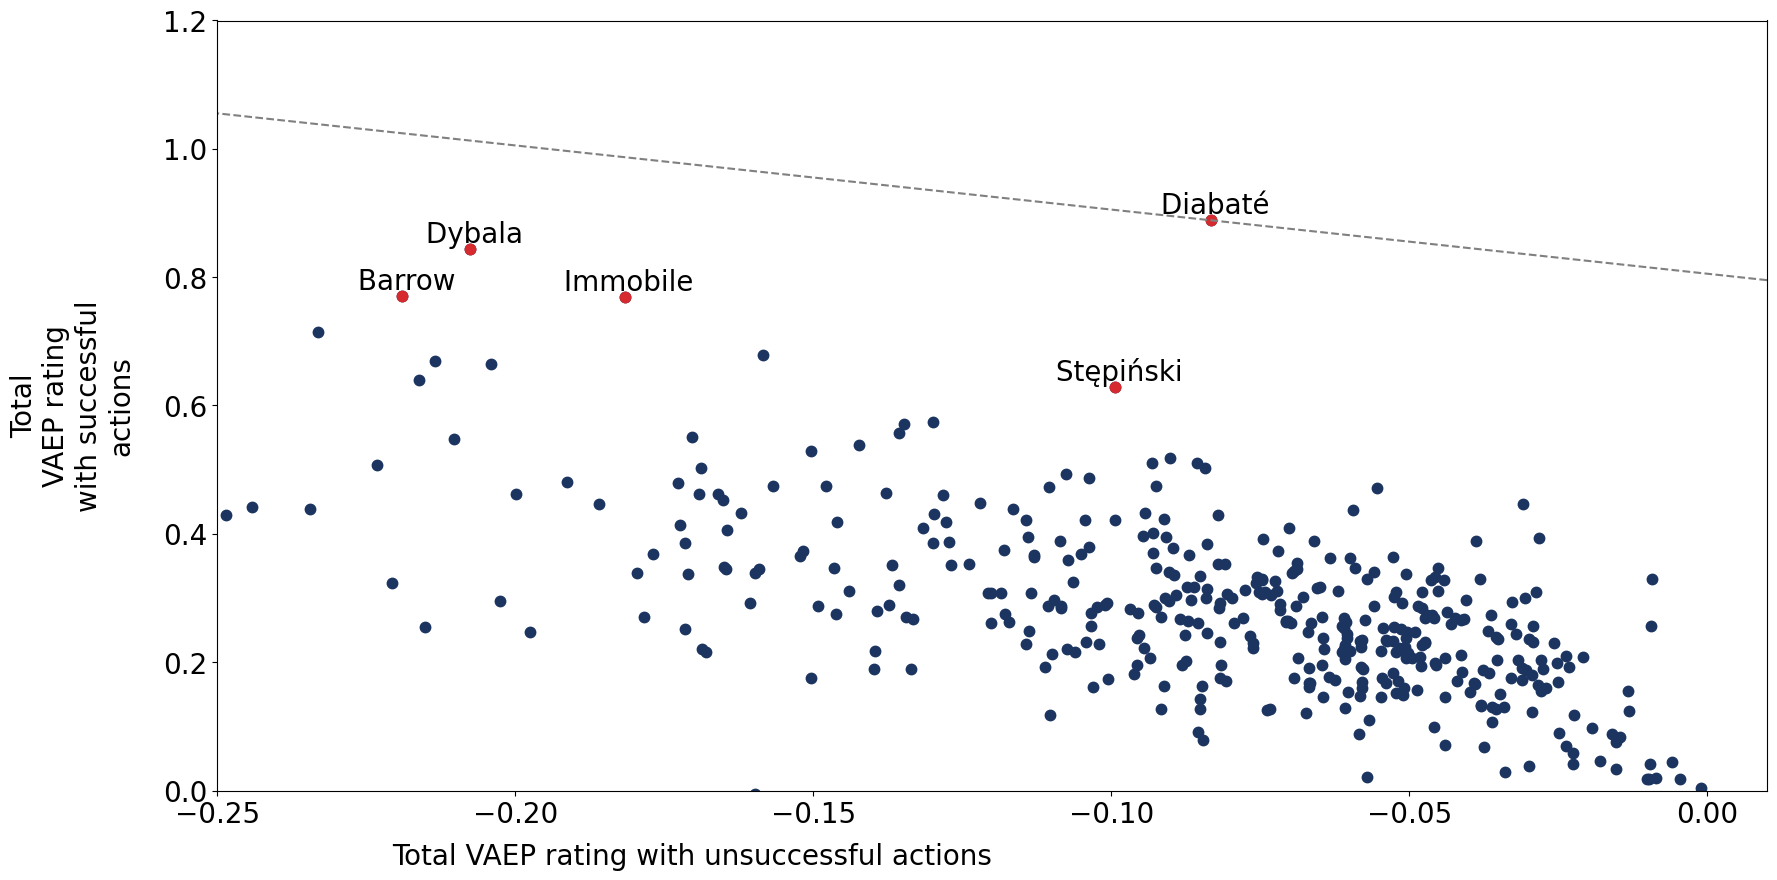

In [337]:
df_risk = df_risk.sort_values('vaep_rating', ascending=False)

plt.figure(figsize=(20, 10))
x = list(df_risk['fail'])
y = list(df_risk['success'])
plt.plot(x, y, '.', c='#1C3460', markersize=15)

# Plot 5 best players
x_best = list(df_risk['fail'][0:5])
y_best = list(df_risk['success'][0:5])
names = list(df_risk['short_name'][0:5])
names = [name.split(".")[-1] for name in names]
plt.plot(x_best, y_best, '.', c='#D62A2E', markersize=15)
for i, txt in enumerate(names):
    plt.annotate(txt, (x[i], y[i] + 0.01), fontsize=20, horizontalalignment='center')

best_player = x[0] + y[0]
yi = np.arange(0.1, 2, 0.1)
xi = [best_player - i for i in yi]
plt.plot(xi, yi, '--', c='grey')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(-0.25, 0.01)
plt.ylim(0, 1.2)
plt.xlabel('Total VAEP rating with unsuccessful actions', rotation=0, labelpad=20,
            verticalalignment='center', horizontalalignment='right', fontsize=20)
plt.ylabel('Total\nVAEP rating\nwith successful\nactions', labelpad=20, fontsize=20)

plt.show()

## Rating per action type

In the next cells we will analyze the rating per player per action type. 

In [338]:
df_rating_action = pd.pivot_table(df_values, values='vaep_value', index=['player_id', 'short_name', 'team_name'],
                                              columns=['type_name'], aggfunc=np.sum,
                                              fill_value=0, margins=True, margins_name='total')
df_rating_action = df_rating_action.reset_index()
df_rating_action = df_rating_action[0:-1]
df_rating_action = pd.merge(df_rating_action, df_minutes_played, on=['player_id'])
for action in df_values['type_name'].unique():
    df_rating_action[action] = df_rating_action[action] / df_rating_action['minutes_played'] * 90

In [339]:
df_rating_action_csv=df_rating_action

In [340]:
df_rating_action[df_rating_action['minutes_played']>MIN_THRESHOLD].sort_values('shot', 
                                                                               ascending=False).head(10)

,player_id,short_name,team_name,clearance,corner_crossed,corner_short,cross,dribble,foul,freekick_crossed,...,keeper_save,pass,shot,shot_freekick,shot_penalty,tackle,take_on,throw_in,total,minutes_played
276,25601.0,C. Diabaté,Benevento Calcio,-0.002741,0.000000,0.000000,0.000000,0.034170,0.007901,0.000000,...,0.0,-0.008234,0.775611,0.000000,0.000000,0.000000,-0.003507,0.000000,6.369461,713.032583
200,21384.0,C. Immobile,SS Lazio,-0.001874,0.000000,-0.000767,-0.008473,0.036426,0.010860,0.000000,...,0.0,-0.022617,0.559399,0.000000,0.005139,0.003644,0.000482,0.000782,18.938157,2907.047792
387,206314.0,M. Icardi,FC Internazionale Milano,0.001252,0.000000,0.000000,-0.005735,0.034299,0.002228,0.000000,...,0.0,-0.002892,0.484615,-0.000149,-0.001288,-0.003502,0.006907,0.000786,17.651383,3060.123799
332,89186.0,P. Dybala,Juventus FC,-0.000697,-0.003734,-0.034289,-0.010133,0.031826,0.005804,0.013590,...,0.0,0.086392,0.476567,0.105297,-0.041009,-0.000618,-0.000393,0.000893,17.442517,2477.563907
341,99511.0,M. Stępiński,AC Chievo Verona,0.010277,0.000000,0.000000,-0.000184,0.031127,0.013737,0.000000,...,0.0,-0.006655,0.473073,0.000000,0.000000,0.003558,-0.006241,0.000000,4.616671,786.332615
496,351010.0,P. Cutrone,AC Milan,-0.002080,0.000000,0.000000,-0.008189,0.013486,0.011076,0.000000,...,0.0,-0.029131,0.413179,0.000000,0.000000,0.001258,-0.002628,0.000297,6.848370,1559.925540
340,99452.0,A. Milik,SSC Napoli,-0.001929,0.000000,0.000000,-0.005559,0.018057,0.003325,0.000000,...,0.0,-0.019366,0.365522,0.000000,0.000000,-0.026952,-0.007561,0.000000,3.703567,1022.777915
546,491409.0,M. Barrow,Atalanta Bergamasca Calcio,0.001393,0.000000,0.000000,0.075813,0.090090,0.013052,0.000000,...,0.0,0.006421,0.363988,0.000000,0.000000,0.000000,-0.004606,0.005561,2.895003,472.201289
322,72397.0,Simy,FC Crotone,0.009808,0.000000,0.000000,-0.001639,0.064779,0.019966,0.000000,...,0.0,-0.001368,0.355258,0.000000,0.000000,0.000000,0.002388,-0.000320,6.415717,1298.807371
492,350032.0,C. Ünder,AS Roma,0.001115,-0.009888,-0.016433,0.010378,0.058001,0.000467,-0.000048,...,0.0,0.017368,0.353731,-0.000161,0.000000,0.000000,0.000033,-0.000311,5.977907,1303.227746


In [341]:
#df_ranking_p90_csv
#df_risk_csv
#df_rating_action_csv

In [342]:
df_ranking_p90_csv.head()

,player_id,short_name,team_id,team_name,vaep_count,vaep_mean,vaep_sum,vaep_sum_Offensive,vaep_mean_Offensive,vaep_sum_defensive,vaep_mean_defensive,minutes_played,vaep_rating,actions_p90
0,21384.0,C. Immobile,3162.0,SS Lazio,1196,0.015835,18.938157,19.549809,0.016346,-0.611651,-0.000511,2907.047792,0.586311,37.027255
1,206314.0,M. Icardi,3161.0,FC Internazionale Milano,709,0.024896,17.651383,18.181736,0.025644,-0.530353,-0.000748,3060.123799,0.519137,20.852098
2,89186.0,P. Dybala,3159.0,Juventus FC,1782,0.009788,17.442517,18.377287,0.010313,-0.934770,-0.000525,2477.563907,0.633617,64.732942
3,265865.0,S. Milinković-Savić,3162.0,SS Lazio,2359,0.006416,15.136493,14.265391,0.006047,0.871102,0.000369,3248.350621,0.419377,65.359324
4,8148.0,Iago Falqué,3185.0,Torino FC,1859,0.007575,14.081121,14.546781,0.007825,-0.465661,-0.000250,2906.319576,0.436050,57.567654


In [343]:
#df_ranking_p90_csv.to_csv('rankingAnalysisEsp.csv', index=False)

In [344]:
df_risk_csv.head()

,player_id,short_name,team_name,success,fail,minutes_played,success_sum,fail_sum,vaep_risk_rating
0,45.0,G. van der Wiel,Cagliari Calcio,0.191914,-0.000149,313.762114,0.669060,-0.000518,0.191765
1,114.0,K. Strootman,AS Roma,0.289281,-0.092856,2354.737384,7.568673,-2.429474,0.196424
2,122.0,D. Mertens,SSC Napoli,0.452098,-0.165195,3577.974246,17.973266,-6.567381,0.286902
3,130.0,S. de Vrij,SS Lazio,0.393593,-0.028305,3144.450117,13.751498,-0.988930,0.365288
4,174.0,F. Đuričić,Benevento Calcio,0.189301,-0.139745,1016.553579,2.138167,-1.578426,0.049556


In [345]:
#df_risk_csv.to_csv('riskAnalysisEsp.csv', index=False)

In [346]:
df_rating_action_csv.head()

,player_id,short_name,team_name,clearance,corner_crossed,corner_short,cross,dribble,foul,freekick_crossed,...,keeper_save,pass,shot,shot_freekick,shot_penalty,tackle,take_on,throw_in,total,minutes_played
0,45.0,G. van der Wiel,Cagliari Calcio,0.007577,0.00000,0.000000,0.015411,-0.005490,0.000000,0.000000,...,0.0,0.149968,-0.003076,0.000000,0.000000,0.000435,0.007443,0.009285,0.646467,313.762114
1,114.0,K. Strootman,AS Roma,0.002720,0.00000,-0.001190,0.000364,0.008639,0.016546,0.002955,...,0.0,0.152596,-0.000689,0.000000,0.000000,0.002349,-0.002175,0.002220,5.039454,2354.737384
2,122.0,D. Mertens,SSC Napoli,0.000598,0.00000,0.000000,-0.009080,0.018455,0.007752,-0.000052,...,0.0,0.020868,0.235017,0.022448,-0.003564,0.000028,-0.009368,-0.000415,11.282742,3577.974246
3,130.0,S. de Vrij,SS Lazio,0.000470,0.00000,0.000000,0.000000,0.000686,0.008405,0.000000,...,0.0,0.194946,0.145061,0.000000,0.000000,0.002164,-0.000094,0.000893,12.698804,3144.450117
4,174.0,F. Đuričić,Benevento Calcio,-0.004804,-0.00425,0.000314,0.027688,0.042223,0.001922,0.000000,...,0.0,0.008673,-0.024649,0.000000,0.000000,-0.004545,-0.000227,0.001751,0.527770,1016.553579


In [347]:
#df_rating_action_csv.to_csv('actionRatingAnalysisEsp.csv', index=False)

In [348]:
df_values_csv.head()

,action_id,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,...,first_name,last_name,birth_date,short_team_name,team_name,scores,concedes,offensive_value,defensive_value,vaep_value
0,0,2575959.0,1.0,2.530536,3158.0,8327.0,53.55,35.36,59.85,29.92,...,Edin,Džeko,1986-03-17,Roma,AS Roma,0.002654,0.000289,0.000000,-0.000000e+00,0.000000
1,1,2575959.0,1.0,3.768418,3158.0,20438.0,59.85,29.92,67.20,11.56,...,Daniele,De Rossi,1983-07-24,Roma,AS Roma,0.003235,0.000407,0.000581,-1.181274e-04,0.000462
2,2,2575959.0,1.0,5.941547,3158.0,8306.0,67.20,11.56,23.10,38.08,...,Aleksandar,Kolarov,1985-11-10,Roma,AS Roma,0.028206,0.001840,0.024972,-1.432360e-03,0.023539
3,3,2575959.0,1.0,8.114676,3158.0,8306.0,23.10,38.08,37.80,10.20,...,Aleksandar,Kolarov,1985-11-10,Roma,AS Roma,0.008769,0.002044,-0.019437,-2.042372e-04,-0.019641
4,4,2575959.0,1.0,8.647892,3158.0,8306.0,37.80,10.20,29.40,10.20,...,Aleksandar,Kolarov,1985-11-10,Roma,AS Roma,0.010320,0.002045,0.001550,-7.830095e-07,0.001550


In [349]:
df_values_csv.to_csv('eventsPerMatchIta.csv', index=False)